In [1]:
import tensorflow as tf
import numpy as np


In [2]:
class Sampling(tf.keras.layers.Layer):
 def call(self, inputs):
  mean, log_var = inputs
  return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [3]:
codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [4]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [5]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [6]:
latent_loss = -0.5 * tf.reduce_sum(
1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [7]:
 #compile the model
 variational_ae.compile(loss="mse", optimizer="nadam")

In [8]:
from sklearn.model_selection import train_test_split
#Load Dataset
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()  # Discard test sets

#Preprocessing
x_train = x_train.astype('float32') / 255.0
x_train = x_train[..., np.newaxis]

#Split into training and validation sets
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [9]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(x_train, x_train, epochs=25, batch_size=128,
validation_data=(x_val, x_val))

Epoch 1/25
375/375 [==============================] - 8s 6ms/step - loss: 0.0525 - val_loss: 0.0387
Epoch 2/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0371 - val_loss: 0.0359
Epoch 3/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0351 - val_loss: 0.0345
Epoch 4/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0340 - val_loss: 0.0337
Epoch 5/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0334 - val_loss: 0.0333
Epoch 6/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0330 - val_loss: 0.0330
Epoch 7/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0327 - val_loss: 0.0326
Epoch 8/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0324 - val_loss: 0.0327
Epoch 9/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0322 - val_loss: 0.0323
Epoch 10/25
375/375 [==============================] - 2s 5ms/step - loss: 0.0321 - val_loss: 0.0321

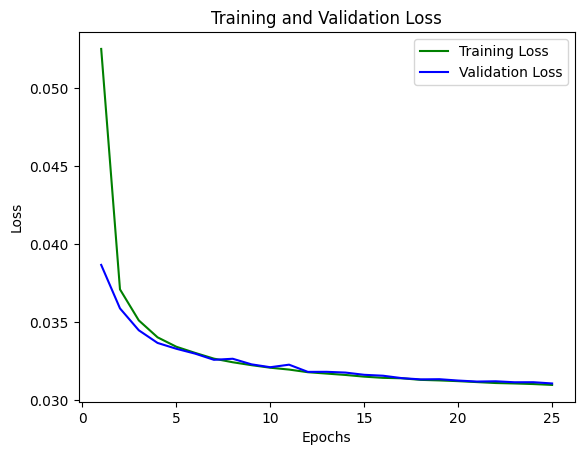

In [10]:
import matplotlib.pyplot as plt

# Extract loss values from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Determine the number of epochs
epochs = range(1, len(training_loss) + 1)

# Create the plot
plt.plot(epochs, training_loss, 'g', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

print(len(images))


21


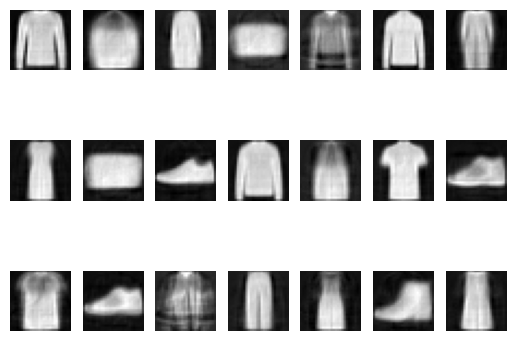

In [12]:
import matplotlib.pyplot as plt

num_images = 3 * 7
for i in range(num_images):
    plt.subplot(3, 7, i+1)
    plt.imshow(images[i, :, :], cmap='gray')
    plt.axis('off')
plt.show()

In [13]:
def plot_reconstructions(model, images=x_val, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


1/1 [==============================] - 0s 186ms/step


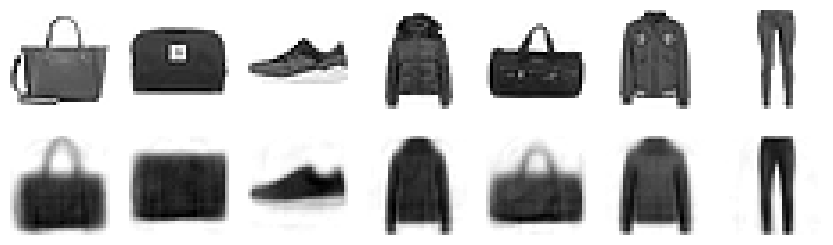

In [14]:
plot_reconstructions(variational_ae, n_images=7)
plt.show()


In [15]:
#define DCGAN model

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 100

generator_d = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                    padding="same", activation="tanh"),
])
discriminator_d = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
gan_d = tf.keras.Sequential([generator_d, discriminator_d])

In [16]:
discriminator_d.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator_d.trainable = False
gan_d.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [17]:
X_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [18]:
# generates the dataset

batch_size = 32
dataset_d = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset_d = dataset_d.shuffle(1000)
dataset_d = dataset_d.batch(batch_size, drop_remainder=True).prefetch(1)

In [19]:
import time
#plot the images
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


#define the training of the gan (fit it to the data)
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):

    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")

        start = time.time()
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        # print("Epoch {}/{}".format(epoch + 1, n_epochs))
        plot_multiple_images(generated_images, 2*8)       # <<< "2*8" is number of columns in the plot grid (4*8 = 32 images)
        plt.show()
        delta = time.time() - start
        print(f'Elapsed time: {delta/60} min')

In [20]:
# Run with 25 epochs
start = time.time()
train_gan(gan_d, dataset_d, batch_size, codings_size, n_epochs=25)
delta = time.time() - start

print(f'Elapsed time: {delta/60} min')


Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 160ms/step


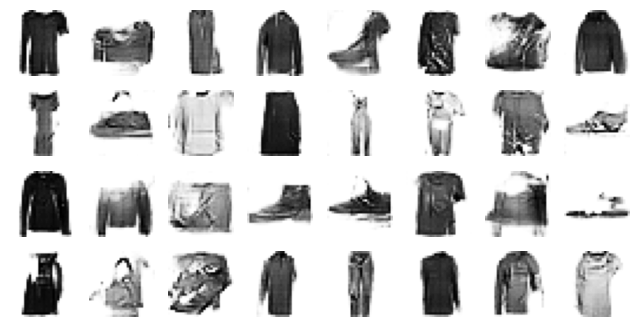

In [21]:
codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator_d.predict(codings)

plot_multiple_images(generated_images, 8)
plt.show()

### GAN achieved slightly better image quality compared to the VAE.